## MNIST

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784')

In [7]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [29]:
type(some_digit)

pandas.core.series.Series

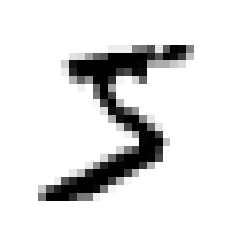

In [48]:
# visualize random digit
from matplotlib import pyplot as plt
import numpy as np

X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)
some_digit = mnist['data'].iloc[0]
some_digit_image = some_digit.values.reshape((28, 28))

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [49]:
# train/test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Train SGD

In [50]:
# target: 5
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

/Users/dvorasindmitrij/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Performance measures

### Accuracy with CV

In [58]:
# write my own cross-validation and get accuracy
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits=3)

for train_index, test_index in skfold.split(X_train, y_train_5):
    clf_clone = clone(sgd_clf)
    
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clf_clone.fit(X_train_folds, y_train_folds)
    results = clf_clone.predict(X_test_fold)
    
    print(sum(results == y_test_fold)/len(results))

0.95035
0.96035
0.9604


In [65]:
# check accuracy of SGD with cross_val_score
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3)

array([0.95035, 0.96035, 0.9604 ])

In [79]:
# create class of always predicting 0, check its accuracy
from sklearn.base import BaseEstimator

class Never5(BaseEstimator):
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype='bool')

In [80]:
never_5 = Never5()
cross_val_score(never_5, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [82]:
# build confusion matrix with cross_val_predict
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred_5 = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
conf_matrix = confusion_matrix(y_train_5, y_pred_5)
conf_matrix

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

In [93]:
print('Precision: ' + str(conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[0][1])))
print('Recall: ' + str(conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[0][0])))

Precision: 0.8370879772350012
Recall: 0.06147469610950507


In [94]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5, y_pred_5))
print(recall_score(y_train_5, y_pred_5))
print(f1_score(y_train_5, y_pred_5))

0.8370879772350012
0.6511713705958311
0.7325171197343846


In [99]:
# get scores instead of prediction classes
y_scores_5 = cross_val_predict(sgd_clf, X_train, y_train_5, method='decision_function')

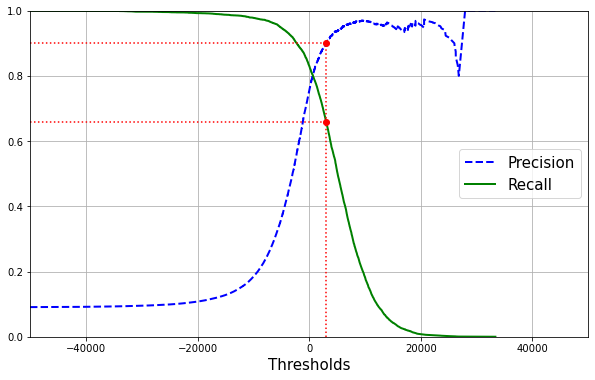

In [199]:
# plot precision and recall as 2 lines
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_5)

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], 'b--', linewidth=2, label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', linewidth=2, label='Recall')
plt.legend(loc='center right', fontsize=15)

# get recall of 90% precision with argmax
recall_with_90_pr = recalls[np.argmax(precisions >= 0.9)]
threshold_with_90_pr = thresholds[np.argmax(precisions >= 0.9)]

plt.plot([threshold_with_90_pr, threshold_with_90_pr], [0., 0.9], 'r:') # vertical red line
plt.plot([-50000, threshold_with_90_pr], [0.9, 0.9], 'r:') # horizontal upper line
plt.plot([-50000, threshold_with_90_pr], [recall_with_90_pr, recall_with_90_pr], 'r:') # horizontal lower line
plt.plot([threshold_with_90_pr], [0.9], 'ro')
plt.plot([threshold_with_90_pr], [recall_with_90_pr], 'ro')
plt.xlim([-50000, 50000])
plt.ylim([0, 1])
plt.xlabel('Thresholds', fontsize=15)
plt.grid(visible=True)
plt.show()

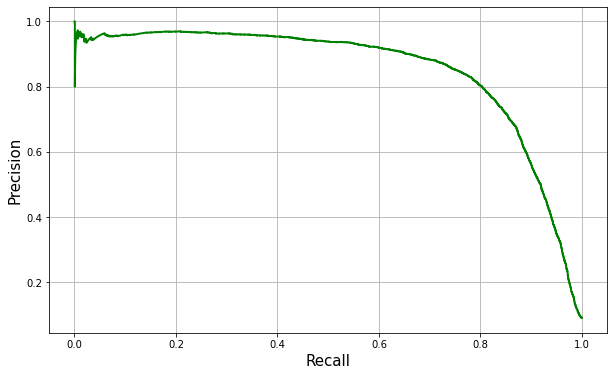

In [233]:
# plot precision vs recall
plt.figure(figsize=(10,6))
plt.plot(recalls[:-1], precisions[:-1], 'g-', linewidth=2)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.grid(visible=True)
plt.show()

In [203]:
y_pred_5_90pr = (y_scores_5 >= threshold_with_90_pr)
print(precision_score(y_train_5, y_pred_5_90pr))
print(recall_score(y_train_5, y_pred_5_90pr))

0.9002016129032258
0.6589190186312488


### ROC

In [223]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest_5 = cross_val_predict(forest_clf, X_train, y_train_5, method='predict_proba')

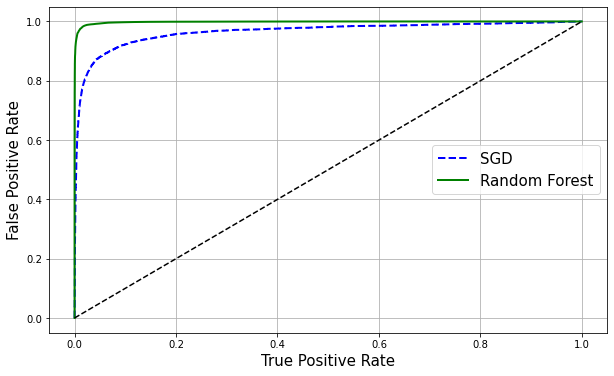

In [238]:
# plot ROC-graphs of sgd and random forest classifiers
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 6))

fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train_5, y_scores_5)
plt.plot(fpr_sgd, tpr_sgd, 'b--', linewidth=2, label='SGD')

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_proba_forest_5[:, 1])
plt.plot(fpr_forest, tpr_forest, 'g-', linewidth=2, label='Random Forest')

plt.plot([0.0, 1.0], [0.0, 1.0], 'k--')
plt.grid(True)
plt.legend(loc='center right', fontsize=15)
plt.xlabel('True Positive Rate', fontsize=15)
plt.ylabel('False Positive Rate', fontsize=15)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.show()

In [231]:
# roc auc
from sklearn.metrics import roc_auc_score
roc_auc_sgd = roc_auc_score(y_train_5, y_scores_5)
roc_auc_forest = roc_auc_score(y_train_5, y_proba_forest_5[:, 1])
print('SGD ROC AUC: ' + str(roc_auc_sgd))
print('Random Forest ROC AUC: ' + str(roc_auc_forest))

SGD ROC AUC: 0.9648211175804801
Random Forest ROC AUC: 0.998402186461512


## Multiclass classification

In [246]:
# SVC: predict, scores for each class and list of classes
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(X_train, y_train)

SVC(random_state=42)

In [245]:
import warnings
warnings.filterwarnings('ignore')

print('Predict for some_digit: ' + str(svc.predict([some_digit])))

print('Scores: ' + str(svc.decision_function([some_digit])))
print('Max score index: ' + str(np.argmax(svc.decision_function([some_digit]))))

print('List of classes: ' + str(svc.classes_))

Predict for some_digit: [5]
Scores: [[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
Max score index: 5
List of classes: [0 1 2 3 4 5 6 7 8 9]


In [247]:
# use SVC and OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier

ovr = OneVsRestClassifier(SVC(random_state=42))
ovr.fit(X_train, y_train)
print('Predict for some_digit: ' + str(ovr.predict([some_digit])))

print('Scores: ' + str(ovr.decision_function([some_digit])))
print('Max score index: ' + str(np.argmax(ovr.decision_function([some_digit]))))

print('List of classes: ' + str(ovr.classes_))

Predict for some_digit: [5]
Scores: [[-2.20788779 -2.52734154 -1.42209483 -0.89545795 -3.66438164  1.09884347
  -3.13930844 -2.05006487 -2.51601851 -3.39312853]]
Max score index: 5
List of classes: [0 1 2 3 4 5 6 7 8 9]


In [248]:
# SGD: predict, scores and cross_val_score
sgd_clf.fit(X_train, y_train)
print('Predict for some_digit: ' + str(sgd_clf.predict([some_digit])))

print('Scores: ' + str(sgd_clf.decision_function([some_digit])))
print('Max score index: ' + str(np.argmax(sgd_clf.decision_function([some_digit]))))

print('CV scores: ' + str(cross_val_score(sgd_clf, X_train, y_train, cv=3)))

Predict for some_digit: [3]
Scores: [[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
Max score index: 3
CV scores: [0.87365 0.85835 0.8689 ]


In [249]:
# scale features and use cross_val_score of SGD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print('CV scores of scaled dataset: ' + str(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3)))

CV scores of scaled dataset: [0.8983 0.891  0.9018]


## Error analysis

In [275]:
# get confusion_matrix
from sklearn.metrics import confusion_matrix

y_train_pred = sgd_clf.predict(X_train_scaled)
conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

array([[5473,   38,   23,    0,    1,  344,   10,   34,    0,    0],
       [   2, 6716,    1,    0,    0,   14,    0,    9,    0,    0],
       [ 314, 1807,  723,   10,   27, 2762,  111,  204,    0,    0],
       [  30, 1758,   10,  147,   10, 3675,   15,  486,    0,    0],
       [ 448, 1896,   16,    0,  457, 2508,   21,  494,    0,    2],
       [  31,  484,    2,    1,    2, 4834,   20,   46,    0,    1],
       [ 197, 1601,   57,    4,    0, 1357, 2695,    7,    0,    0],
       [  21,  265,    2,    3,    0,  132,    1, 5834,    0,    7],
       [  93, 2678,   10,    0,    0, 2933,    9,  128,    0,    0],
       [  86,  640,   10,    0,   11, 2834,    0, 2346,    0,   22]])

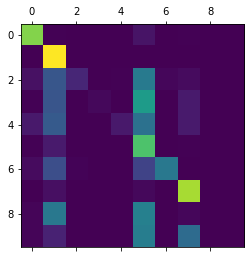

In [270]:
# visualize matrix with matshow
plt.matshow(conf_matrix)
plt.show()

In [268]:
# get relative values in matrix and fill diagonal with 0

rows_count = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / rows_count
np.fill_diagonal(norm_conf_matrix, 0)

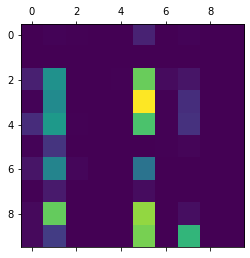

In [271]:
plt.matshow(norm_conf_matrix)
plt.show()

In [272]:
# Ageron's function
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

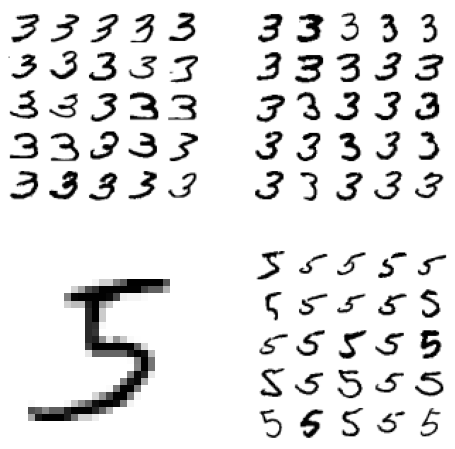

In [277]:
# visualize digits with prewritten function (copied from book)
import matplotlib as mpl

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


## Multilabel Classification

In [284]:
# fit KNN on two labels: [> 7, odd]
y_big_number = (y_train >= 7)
y_odd = (y_train % 2 == 0)
y_train_multilabel = np.c_[y_big_number, y_odd]

from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
#knn_clf.fit(X_train_scaled, y_train_multilabel)
y_train_pred_multilabel = cross_val_predict(knn_clf, X_train_scaled, y_train_multilabel, cv=3)
y_train_pred_multilabel

array([[False, False],
       [False,  True],
       [False,  True],
       ...,
       [False, False],
       [False,  True],
       [ True,  True]])

In [285]:
# f1-score
print('F1-score macro: ' + str(f1_score(y_train_multilabel, y_train_pred_multilabel, average='macro')))
print('F1-score weighted: ' + str(f1_score(y_train_multilabel, y_train_pred_multilabel, average='weighted')))

F1-score macro: 0.9605970395964663
F1-score weighted: 0.9624944811954473


## Multioutput Classification

In [316]:
# prepare datasets for image clearing classifier
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)
some_index = np.random.randint(0, len(X_test_mod))
y_test_pred = knn_clf.predict([X_test_mod.iloc[some_index]])

In [318]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [326]:
type(X_test_mod.iloc[some_index])

pandas.core.series.Series

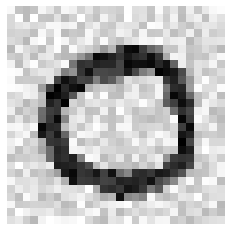

In [327]:
# noisy
plot_digit(np.array(X_test_mod.iloc[some_index]))

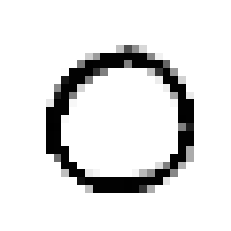

In [321]:
# predict
plot_digit(y_test_pred)

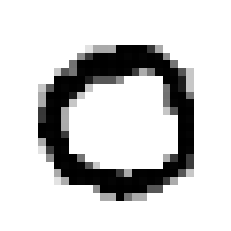

In [335]:
# true
plot_digit(np.array(y_test_mod.iloc[some_index]))